<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Transfer Learning in Computer Vision
Rather than creating our own model from scratch, we can use models which have been pre-trained on other generic tasks to take advantage of the training that has already occurred.  When we do this, we usually keep the model parameters fixed except for the last layer.  We use a new last layer (a fully connected Linear layer) which we then train on our specific task.  One way to think about this approach is that the pre-trained layers act as "feature detectors" which identify feature patterns within the images.  These features are then fed into the final fully-connected layer which attempts to classify the image based on the input features it receives from the rest of the model.

Most commonly we use models which have been pre-treained on the ImageNet dataset.  All models pre-trained on ImageNet expect input images to be normalized in the same way, i.e. mini-batches of 3-channel RGB images with each image having shape (3 x H x W), where H and W are expected to be at least 224 pixels. The pixel values should be first scaled to a range of [0, 1] (accomplished by using `transforms.ToTensor()`) and then normalized using the mean and standard deviation of image pixel values across the image dataset.  Since it can be difficult to calculate these statistics, we often just normalize by the mean and standard deviation of the ImageNet images, which are mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize: `normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])`

**Notes:**
- This notebook should be run on GPU, although the first part can run on CPU in 10-15 minutes

**References:**
- This notebook includes example code adapted from the [PyTorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)


In [ ]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "class_demos" # Enter repo name
git_path = 'https://github.com/AIPI540/class_demos.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = 'computer_vision'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [37]:
import os
import urllib.request
import zipfile
import copy
import time
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  1.10.0


## Transfer Learning Example
In this example we will create a classifier capable distinguishing between images of ants and bees.  We will use a ResNet18 model which has been pre-trained on ImageNet and we will conduct fine-tuning training for our specific task.

In [2]:
# Download the data
if not os.path.exists('data/hymenoptera_data'):
    url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
    urllib.request.urlretrieve(url,filename='data/hymenoptera_data.zip')
    zip_ref = zipfile.ZipFile('data/hymenoptera_data.zip', 'r')
    zip_ref.extractall('data/')
    zip_ref.close()

### Set up dataloaders for our data
We will first create and apply a pipeline of transformations to apply to our images before feeding them into the model.  We apply data augmentation techniques such as random cropping and random horizontal flipping to our training data to make our model more robust to different layouts of objects in images.  We apply normalization to both the training and validation (test) sets.  Since we are using a model pre-trained on ImageNet, our model expects input images to be normalized in the same way, i.e. mini-batches of 3-channel RGB images each having shape (3 x H x W), where H and W are expected to be at least 224 pixels. The pixel values should be first scaled to a range of [0, 1] (accomplished by using `transforms.ToTensor()`) and then normalized using the mean and standard deviation of image pixel values across the image dataset.  Since it can be difficult to calculate these statistics, we will just normalize by the mean and standard deviation of the ImageNet images, which are mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [14]:
data_dir = 'data/hymenoptera_data'

# Set up transformations for training and validation (test) data
# For training data we will do randomized cropping to get to 224 * 224, randomized horizontal flipping, and normalization
# For test set we will do only center cropping to get to 224 * 224 and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create Datasets for training and validation sets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms['val'])

# Create DataLoaders for training and validation sets
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=4)


# Store size of training and validation sets
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}
# Get class names associated with labels
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([4, 3, 224, 224])


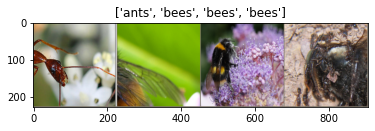

In [5]:
def imshow(inp, title=None):
    # Visualize images stored as Tensors
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
images, labels = next(iter(train_loader))
print(images.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in labels])


As we see above, the inputs in a PyTorch DataLoader are of shape [N,C,H,W) where:  
- N = batch size  
- C = number of channels (1 for grayscale, 3 for RGB color)  
- H = image height  
- W = image width

### Define our model architecture
We will used a pre-trained ResNet18 model, so our architecture has already been defined.  However, we will replace the ResNet's final layer with a new fully connected Linear layer which we will train on our specific task

In [33]:
# Instantiate pre-trained resnet
net = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in net.parameters():
    param.requires_grad = False

# Get the number of inputs to final Linear layer
num_ftrs = net.fc.in_features
# Replace final Linear layer with a new Linear with the same number of inputs but just 2 outputs,
# since we have 2 classes - bees and ants
net.fc = nn.Linear(num_ftrs, 2)

### Define cost function and optimizer
We will use Cross Entropy as the cost/loss function and SGD for the optimizer.

In [34]:
# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the model

In [35]:
def train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # Step along learning rate scheduler when in train
            if phase == 'train':
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model

In [36]:
# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}

# Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model
model_ft = train_model(net, criterion, optimizer, dataloaders, lr_scheduler, device, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5762 Acc: 0.6803
val Loss: 0.3777 Acc: 0.8301

Epoch 1/9
----------
train Loss: 0.5878 Acc: 0.7623
val Loss: 0.2015 Acc: 0.9412

Epoch 2/9
----------
train Loss: 0.4959 Acc: 0.8074
val Loss: 0.2186 Acc: 0.9281

Epoch 3/9
----------
train Loss: 0.3867 Acc: 0.8238
val Loss: 0.2951 Acc: 0.9020

Epoch 4/9
----------
train Loss: 0.3814 Acc: 0.8402
val Loss: 0.1961 Acc: 0.9346

Epoch 5/9
----------
train Loss: 0.4765 Acc: 0.7910
val Loss: 0.2125 Acc: 0.9412

Epoch 6/9
----------
train Loss: 0.4611 Acc: 0.8156
val Loss: 0.2554 Acc: 0.9281

Epoch 7/9
----------
train Loss: 0.3385 Acc: 0.8402
val Loss: 0.2022 Acc: 0.9412

Epoch 8/9
----------
train Loss: 0.3365 Acc: 0.8361
val Loss: 0.2220 Acc: 0.9412

Epoch 9/9
----------
train Loss: 0.4533 Acc: 0.8074
val Loss: 0.2008 Acc: 0.9412

Training complete in 11m 29s
Best val Acc: 0.941176


### Visualize results

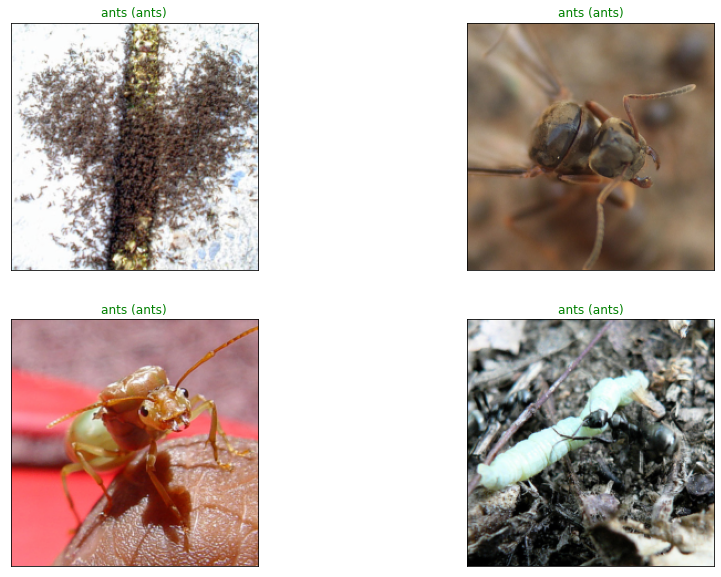

In [32]:
def visualize_results(net,dataloader,device):
    with torch.no_grad():
        net.eval()
        # Get a batch of validation images
        images, labels = iter(val_loader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(net(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(net,val_loader,device)

## Transfer Learning on FashionMNIST
In this example we will load a ResNet18 model and use it on the FashionMNIST dataset. The FashionMNIST dataset has a couple of differences relative to the ImageNet dataset on which pretrained models are trained:  
- It is grayscale so has only 1 channel instead of 3. 
- It is 28 * 28 rather than 224 * 224. 
- The mean and standard deviation of pixel values across the FashionMNIST dataset are quite different from the images in ImageNet  
- We have only 10 classes as output rather than 1000 as in ImageNet

Because of those differences, we need to make two adjustments to use our pretrained model:  
1) We need to transform our input image data to be 224*224 and normalize using the images mean and standard deviation  
2) We need to change our net architecture to accomodate 1 input channel, and 10 output classes

In [ ]:
# We need to add a transformation to our input image data
# Resnet18 expects input images of shape 224*224
# We also should normalize our pixel values by subracting mean and dividing by standard deviation of training set values

train_data = FashionMNIST(root='data', train=True, download=True)

data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((train_data.data.float().mean()/255), (train_data.data.float().std()/255))])

train_data_resnet = FashionMNIST(root='data', train=True,
                                   download=True, transform=data_transform)

test_data_resnet = FashionMNIST(root='data', train=False,
                                  download=True, transform=data_transform)

batch_size = 16
train_loader_resnet = DataLoader(train_data_resnet,batch_size=batch_size, shuffle=True)
test_loader_resnet = DataLoader(test_data_resnet,batch_size=batch_size, shuffle=False)

# Specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Set random seeds for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

In [ ]:
# Load a resnet18 pre-trained model
model_resnet = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model_resnet.parameters():
    param.requires_grad = False
    
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was trained on color (3 input channels)
in_channels = 1
model_resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is number of classes (10)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 10)

# Train the model
n_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model(model_resnet,criterion,optimizer,train_loader_resnet,n_epochs,device)

# Visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Batch (1000s)')
plt.ylabel('loss')
plt.show()

In [ ]:
# Test the pre-trained model
acc,recall_vals = test_model(model_resnet,test_loader_resnet,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(10):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))